In [1]:
#Regressão univariada

In [2]:
#importa a biblioteca que cria a seção do spark
from pyspark.sql import SparkSession

In [3]:
#inicia a seção para a utilização do spark
spark = SparkSession\
    .builder\
    .appName("RegressaoLinear")\
    .getOrCreate() #cria a seção caso não exista ou obtém a já criada

23/01/09 23:59:15 WARN Utils: Your hostname, Deboras-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.68.104 instead (on interface en0)
23/01/09 23:59:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/09 23:59:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#define o diretório que contém o arquivo a ser utilizado
diretorioRegressao="./data/regressaoLinear.csv" 

In [5]:
#importa os tipos
from pyspark.sql.types import * 

#define o esquema dos dados a serem lidos
#Define o tipo como struct, chama a variável independete de X e define como inteiro e chama a variável dependente de Y e define como string
#Para não dar erro depois, tem que chamar de X e Y
schema=StructType().add("X",IntegerType(),True).add("Y",StringType(),True)

In [6]:
#carrega o arquivo no Spark com o esquema definido
pagamentoSeguro = spark.read.format('csv').schema(schema).options(header='true',delimiter=';').load(diretorioRegressao)

In [7]:
#checa se esquema foi corretamente carregado
pagamentoSeguro.printSchema()

root
 |-- X: integer (nullable = true)
 |-- Y: string (nullable = true)



In [8]:
#mostra os primeiros 5 dados
pagamentoSeguro.show(5)

+---+-----+
|  X|    Y|
+---+-----+
|108|392,5|
| 19| 46,2|
| 13| 15,7|
|124|422,2|
| 40|119,4|
+---+-----+
only showing top 5 rows



In [9]:
#importa funções
import pyspark.sql.functions as F

#Altera o nome das variáveis para "Apolices" e "Valor_Pago"
pagamentoSeguro=pagamentoSeguro.select(F.col('X').alias("Apolices"), F.col('Y').alias("Valor_Pago"))  #adiciona nomes ao cabaçalho

In [10]:
#checa alteração
pagamentoSeguro.show(5)

+--------+----------+
|Apolices|Valor_Pago|
+--------+----------+
|     108|     392,5|
|      19|      46,2|
|      13|      15,7|
|     124|     422,2|
|      40|     119,4|
+--------+----------+
only showing top 5 rows



In [11]:
#Como os algoritmos separam inteiro de decimal com ".", cria uma nova coluna com "." no lugar da ","
#Para que isso funcione, foi necessário definir o esquema com a variável Y como string!
pagamentoSeguroPonto=pagamentoSeguro.withColumn("Valor_Pago_Novo", F.regexp_replace(F.col("Valor_Pago"), "[,]", ".")) 

In [12]:
#checa alteração
pagamentoSeguroPonto.show(5)

+--------+----------+---------------+
|Apolices|Valor_Pago|Valor_Pago_Novo|
+--------+----------+---------------+
|     108|     392,5|          392.5|
|      19|      46,2|           46.2|
|      13|      15,7|           15.7|
|     124|     422,2|          422.2|
|      40|     119,4|          119.4|
+--------+----------+---------------+
only showing top 5 rows



In [13]:
#Feita a substituição, transforma o tipo string para numérico
pagamentoSeguroFinal=pagamentoSeguroPonto.select(F.col('Apolices'),F.col('Valor_Pago_Novo'), pagamentoSeguroPonto.Valor_Pago_Novo.cast('float').alias('Valor_Pago_Float'))

In [14]:
#checa alteração
pagamentoSeguroFinal.show(5)

+--------+---------------+----------------+
|Apolices|Valor_Pago_Novo|Valor_Pago_Float|
+--------+---------------+----------------+
|     108|          392.5|           392.5|
|      19|           46.2|            46.2|
|      13|           15.7|            15.7|
|     124|          422.2|           422.2|
|      40|          119.4|           119.4|
+--------+---------------+----------------+
only showing top 5 rows



In [15]:
#verifica esquema
pagamentoSeguroFinal.printSchema()

root
 |-- Apolices: integer (nullable = true)
 |-- Valor_Pago_Novo: string (nullable = true)
 |-- Valor_Pago_Float: float (nullable = true)



Iniciando o Processo de Regressão

In [16]:
#mostra informações básicas sobre os dados: count, mean, stddev, min e max
pagamentoSeguroFinal.describe().show()

+-------+------------------+-----------------+-----------------+
|summary|          Apolices|  Valor_Pago_Novo| Valor_Pago_Float|
+-------+------------------+-----------------+-----------------+
|  count|                63|               63|               63|
|   mean|22.904761904761905|98.18730158730159|98.18730196877131|
| stddev| 23.35194561605733|87.32755263404981|87.32755386147541|
|    min|                 0|                0|              0.0|
|    max|               124|             98.1|            422.2|
+-------+------------------+-----------------+-----------------+



In [20]:
#importa a biblioteca responsável por criar o vetor a partir da coluna
from pyspark.ml.feature import VectorAssembler

#transformando os dados (linhas) em vetores que poderão ser lidos pelo algoritmo
#define o objeto para transformação
assembler = VectorAssembler(inputCols=['Apolices'], outputCol='features')  

#aplica a transformação
df_seguro = assembler.transform(pagamentoSeguroFinal)

# #verifica esquema
df_seguro.printSchema()

root
 |-- Apolices: integer (nullable = true)
 |-- Valor_Pago_Novo: string (nullable = true)
 |-- Valor_Pago_Float: float (nullable = true)
 |-- features: vector (nullable = true)



In [21]:
#seleciona apenas colunas de interesse
df_seguro = df_seguro.select(['features','Valor_Pago_Float'])

#checa alterações
df_seguro.show(5)

+--------+----------------+
|features|Valor_Pago_Float|
+--------+----------------+
| [108.0]|           392.5|
|  [19.0]|            46.2|
|  [13.0]|            15.7|
| [124.0]|           422.2|
|  [40.0]|           119.4|
+--------+----------------+
only showing top 5 rows



Criando o Modelo de Regressão

In [22]:
# importa biblioteca que contém o modelo de regressão
from pyspark.ml.regression import LinearRegression

#define o objeto a ser utilizado para regressão com máxima interação = 10 e a coluna Valor_Pago_Float como target (variável dependente)
lr = LinearRegression(maxIter=10, labelCol='Valor_Pago_Float') 

#cria o modelo de regressão linear com os parâmetros ajustados
lrModel = lr.fit(df_seguro)

23/01/10 00:03:41 WARN Instrumentation: [14a9ab7c] regParam is zero, which might cause numerical instability and overfitting.
23/01/10 00:03:41 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/01/10 00:03:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/01/10 00:03:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/01/10 00:03:41 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [23]:
#Mostra coeficientes angulares e lineares (a e b) da reta de regressão
print(f'Intercepto: {lrModel.intercept}\nCoeficiente Angular: {lrModel.coefficients.values}')

Intercepto: 19.994485035718697
Coeficiente Angular: [3.41382361]


In [24]:
#print das estatísticas do modelo
modelsummary = lrModel.summary

print("Variância Explicada:", modelsummary.explainedVariance)
print('R_2: ', modelsummary.r2)
print('Erro médio quadrático: ',modelsummary.meanSquaredError)

modelsummary.residuals.show(5)


Variância Explicada: 6254.310467068246
R_2:  0.8333466721037774
Erro médio quadrático:  1250.7419636077982
+-------------------+
|          residuals|
+-------------------+
| 3.8125652674761454|
| -38.65713283055052|
| -48.67419213440233|
|-21.108600258352624|
| -37.14742784198987|
+-------------------+
only showing top 5 rows



Realizando a Previsão Através do Modelo

In [25]:
modelsummary.predictions.show(5)

+--------+------------------+------------------+
|features|  Valor_Pago_Float|        prediction|
+--------+------------------+------------------+
| [108.0]|             392.5|388.68743473252385|
|  [19.0]| 46.20000076293945| 84.85713359348998|
|  [13.0]|15.699999809265137| 64.37419194366747|
| [124.0]|422.20001220703125| 443.3086124653839|
|  [40.0]| 119.4000015258789|156.54742936786877|
+--------+------------------+------------------+
only showing top 5 rows



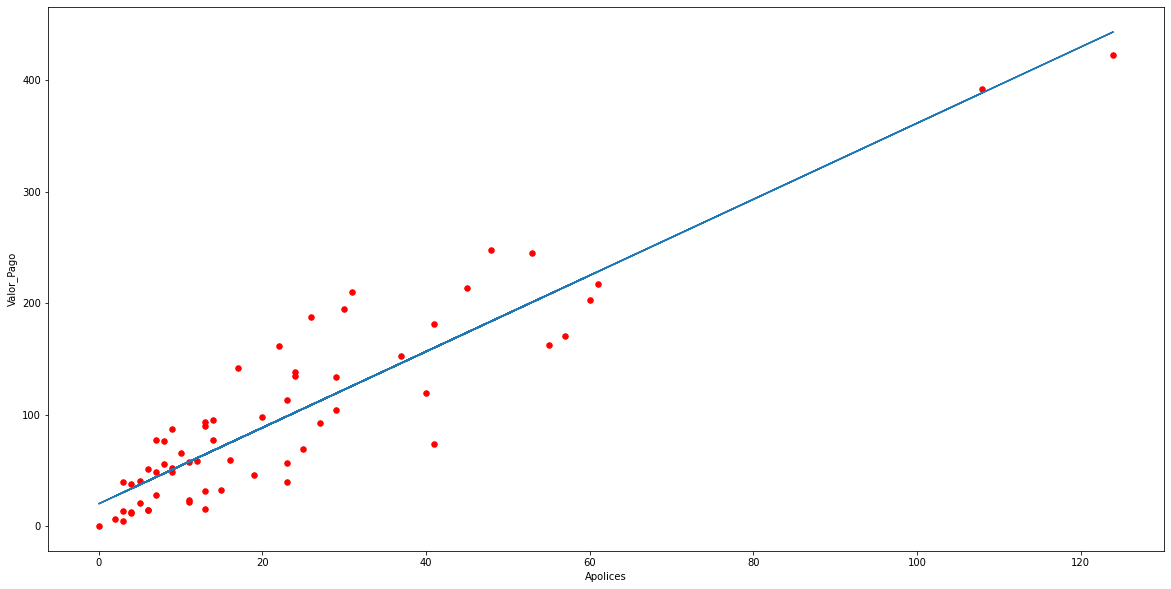

In [37]:
import matplotlib.pyplot as plt #biblioteca para criar gráficos "comuns" ao estilo Matlab
import numpy as np

#define layout
plt.figure(figsize=(20,10))

#transforma dados vetor para pandas para serem plotados
x1 = modelsummary.predictions.toPandas()['features'].values.tolist()
y1 = modelsummary.predictions.toPandas()['Valor_Pago_Float'].values.tolist()
y_pred = modelsummary.predictions.toPandas()['prediction'].values.tolist()


#plota gráfico de pontos das observações
plt.scatter(x1, y1, color='red', s=30)

#plota linha
plt.plot(x1,y_pred)

#nomeia eixos
plt.xlabel('Apolices')
plt.ylabel('Valor_Pago')

#imprime na tela
plt.show()